# VGG-16

ImageNet 데이터셋에서 사전에 파라미터를 학습한 VGG-16 모델로 미지의 화상을 분류하는 프로그램을 구현하겠다.

VGG-16 모델은 2014년 ILSVRC에서 2위를 차지한 합성곱 신경망이다. 옥스퍼드 대학교의 VGG 팀이 16층으로 구성한 모델이므로 VGG-16 모델로 불린다. 11, 13, 19층 버전의 VGG 모델도 존재한다.

### 데이터

In [1]:
!git clone https://github.com/YutaroOgawa/pytorch_advanced.git
!cd pytorch advanced/
!cd 1_image_classification/

fatal: destination path 'pytorch_advanced' already exists and is not an empty directory.
/bin/bash: line 0: cd: too many arguments
/bin/bash: line 0: cd: 1_image_classification/: No such file or directory


In [2]:
import os
import urllib.request
import zipfile

In [3]:
# フォルダ「data」が存在しない場合は作成する
data_dir = "/content/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [4]:
# ImageNetのclass_indexをダウンロードする
# Kerasで用意されているものです
# https://github.com/fchollet/deep-learning-models/blob/master/imagenet_utils.py

url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
save_path = os.path.join(data_dir, "imagenet_class_index.json")

if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path)

In [5]:
# 1.3節で使用するアリとハチの画像データをダウンロードし解凍します
# PyTorchのチュートリアルで用意されているものです
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
save_path = os.path.join(data_dir, "hymenoptera_data.zip")

if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path)

    # ZIPファイルを読み込み
    zip = zipfile.ZipFile(save_path)
    zip.extractall(data_dir)  # ZIPを解凍
    zip.close()  # ZIPファイルをクローズ

    # ZIPファイルを消去
    os.remove(save_path)

### 패키지

In [6]:
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torchvision import models, transforms

In [7]:
print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu116
0.14.1+cu116


### 학습된 VGG-16 모델 읽기

In [8]:
use_pretrained = True # 학습된 파라미터 사용
net = models.vgg16(pretrained=use_pretrained)
net.eval() # 추론 모드(평가 모드)로 설정

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

출력 결과를 보면 VGG-16 모델의 네티워크 구성은 features와 classifier라는 두 모듈로 나누어져있다. 그리고 각 모듈 속에 합성곱 층과 전결합 층이 있다.

VGG-16은 이름처럼 16층이 아닌 총 38층으로 구성되어있다. 16층이란 합성곱 층과 전겨합 층의 수를 나타낸다.(활성화 함수 ReLU, 풀링 층, 드롭아웃 층은 포함하지 않는다.)

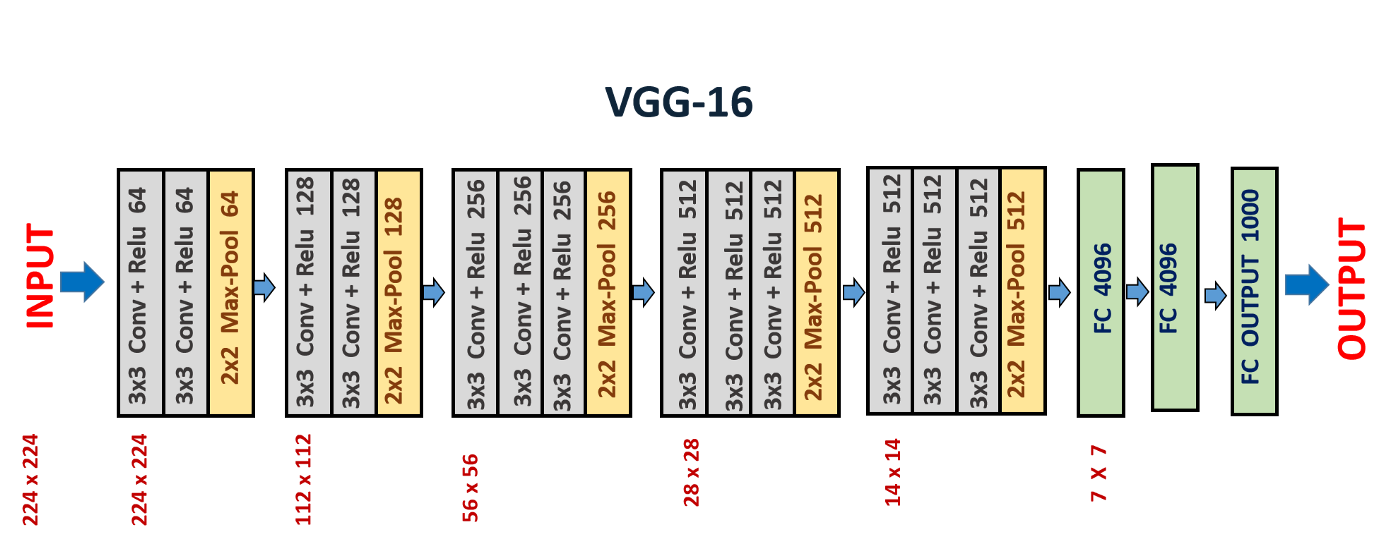

입력 화상의 크기는 RGB 색상 채널 3, 높이와 너비가 224 픽셀이므로 (batch_num, 3, 224, 224)가 된다. batch_num은 미니 배치의 사이즈를 나타낸 것이다.

입력화상은 처음에 3x3 크기의 합성곱 필터(64채널), 활성화 함수 ReLU 쌍을 두 번 통과하고, 이후 2x2 크기의 최대 풀링(Max Pooling)층을 통과한다. 그 결과 화상의 크기는 절반인 112 x 112가 된다. 합성곱 층, ReLU, 최대 풀링 조합을 총 다섯 번 통과하고 최종적으로 features 모듈의 끝에 있는 최대 풀링을 빠져나오면 데이터 크기는 (512, 7, 7)이 된다.

입력 데이터는 features 모듈을 통과한 후 classifier 모듈에 들어간다. 첫번째 전결합 층은 입력 요소 수가 25088, 출력 수가 4096이다. 25088이라는 숫자는 classifier 모듈에 대한 입력 화상의 전체 요소 수인 512 x 7 x 7 = 25088로 계산된 것이다. 

전결합 층 이후에는 ReLU, 드롭아웃 층을 통과한다. 여기에 다시 한 번 전결합 층, ReLU, 드롭아웃 조합을 통과하여 마지막에는 출력 유닛 수가 1000인 전결합 층을 통과한다. 출력 수 1000의 출력 유닛은 ImageNet 데이터셋의 클래스 수 1000 종류에 대응하며, 1000 클래스 중 입력 화상이 어디에 해당하는지 나타낸다.

In [9]:
import torchsummary
torchsummary.summary(net, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

### 입력 영상의 전처리 클래스 작성

학습된 VGG-16 모델을 읽은 후에는 VGG-16 화상을 입력하는 데 필요한 전처리 부분을 작성한다.

전처리로 화상 크기를 224x224로 변경하고 색상 정보를 규격화해야 한다. 색상 정보의 규격화는 RGB를 평균 (0.485, 0.456, 0.406), 표준편차 (0.229, 0.224, 0.225)의 조건으로 표준화한다. 해당 규격화 조건은 ILSVRC2012 데이터셋의 지도 데이터로 구해지는 값이다. 방금 읽어들인 학습된 VGG-16 모델은 이 규격화 조건으로 전처리된 화상을 학습하여 같은 전처리를 해야 한다.

화상의 전처리 클래스를 구현한다. BaseTransform 클래스를 만들어 동작을 확인한다.

파이토치와 필로(pillow)(PIL)에서 화상 요소의 순서가 다른 점에 주의해야 한다. 파이토치는 화상을 (색상 채널, 높이, 너비) 순서로 다루지만 필로는 (높이, 너비, 색상 채널) 순으로 다룬다. 파이토치에서 출력의 텐서의 순서를 다음과 같이 교체한다.

      img_transformed = img_transformed.numpy().transpose((1,2,0))



\__call__()은 파이썬의 일반 메서드이다. 해당 클래스의 인스턴스를 구체적인 함수를 지정하지 않고 호출하면 실행되는 함수이다. BaseTransform의 인스턴스를 생성한 후 함수를 지정하지 않고 인스턴스명으로 실행하면 \__call__()이 실행 된다.

        resize : int
            크기 변경 전의 화상 크기
        mean : (R, G, B)
            각 색상 채널의 평균값
        std : (R, G, B)
            각 색상 채널의 표준편차

In [10]:
class BaseTransform():
  def __init__(self, resize, mean, std):
    self.base_transform = transforms.Compose([
        transforms.Resize(resize), # 짧은 변의 길이가 resize 크기가 된다.
        transforms.CenterCrop(resize), # 화상 중앙을 resize x resize로 자른다.
        transforms.ToTensor(), # 토치 텐서로 변환
        transforms.Normalize(mean, std) # 색상 정보의 표준화
        ])
  def __call__(self, img):
    return self.base_transform(img)

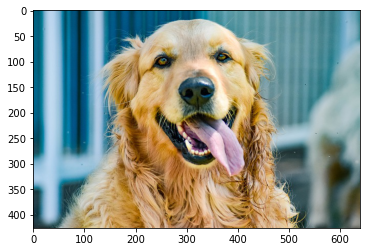

In [11]:
# 1. 화상 읽기
image_file_path = '/content/pytorch_advanced/1_image_classification/data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path) # [높이][너비][색]
plt.imshow(img)

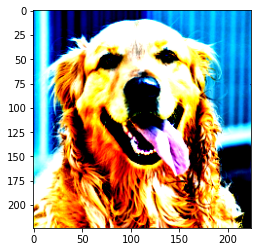

In [12]:
# 2. 화상 전처리 및 처리된 화상의 표시
resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = BaseTransform(resize, mean, std)
img_transformed = transform(img) # torch.Size([3, 224, 224])

# (색상, 높이, 너비)를 (높이, 너비, 색상)으로 변환하고 0-1로 값을 제한하여 표시
img_transformed = img_transformed.numpy().transpose((1,2,0))
img_transformed = np.clip(img_transformed, 0, 1)

plt.imshow(img_transformed)

### 출력 결과로 라벨을 예측하는 후처리 클래스 생성

VGG-16 모델의 1000차원 출력을 라벨명으로 변환하는 ILSVRCPredictor 클래스를 만든다. ILSVRC의 라벨명은 사전에 준비한 JSON 파일인 imagenet_class_index.json을 사용한다.

VGG-16 모델로 출력된 값은 torch.Size([1, 1000]) 크기의 파이토치 텐서 형식이다. 이를 넘파이형 변수로 변환한다. 먼저 출력 값을 네티워크에서 분리하는 .detach()를 적용한다. 분리한 텐서에 .numpy()를 적용하여 넘파이형으로 변환하고 np.argmax()로 최대값의 인덱스를 얻는다.

    maxid = np.argmax(out.detach().numpy())

이후에는 maxid에 해당하는 라벨명을 사전형 변수 ILSVRC_class_index에서 얻는다.

In [13]:
# ILSVRC 라벨 정보를 읽어 사전형 변수 생성
ILSVRC_class_index = json.load(open('/content/imagenet_class_index.json', 'r'))
ILSVRC_class_index

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

In [14]:
# 출력 결과에서 라벨을 예측하는 후처리 클래스
class ILSVRCPredictor():
  def __init__(self, class_index):
    self.class_index = class_index
  
  def predict_max(self, out):
    maxid = np.argmax(out.detach().numpy())
    predicted_label_name = self.class_index[str(maxid)][1]

    return predicted_label_name

### 학습된 VGG 모델로 화상 예측

화상 전처리용 BaseTransform 클래스와 네트워크 출력의 후처리용 ILSVRCPredictor 클래스를 만들었다. 

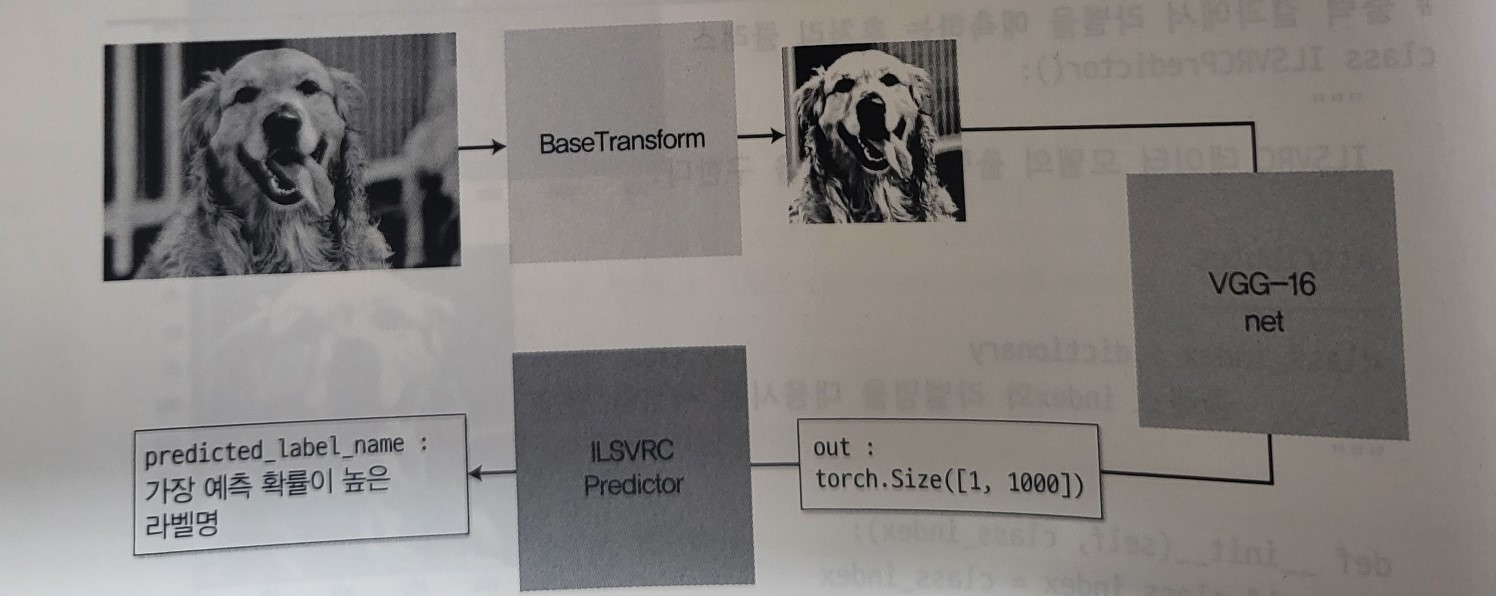

이러한 흐름을 구현하여 학습된 VGG 모델로 화상을 예측한다. 파이토치 네트워크에 화상을 입력할 때 데이터를 미니 배치 형태로 해야한다. unsqueeze_(0)을 사용하여 입력 데이터에 미니 배치의 차원을 추가한다.

In [15]:
# ILSVRC 라벨 정보를 읽어 사전형 변수 생성
ILSVRC_class_index = json.load(open('/content/imagenet_class_index.json', 'r'))

In [16]:
# ILSVRCPredictor 인스턴스 생성
predictor = ILSVRCPredictor(ILSVRC_class_index)

In [17]:
# 입력 화상 읽기
image_file_path = '/content/pytorch_advanced/1_image_classification/data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path) # [높이][너비][색]

In [18]:
# 전처리 후 배치 크기의 차원 추가
transform = BaseTransform(resize, mean, std)
img_transformed = transform(img) # torch.Size([3, 224, 224])
inputs = img_transformed.unsqueeze_(0) # torch.size([1, 3, 224, 224])

In [19]:
# 모델에 입력하고 모델 출력을 라벨로 변환
out = net(inputs) # torch.Size([1, 1000])
result = predictor.predict_max(out)
print('입력 화상의 예측 결과 : ', result)

입력 화상의 예측 결과 :  golden_retriever
